# 引言
# 预备知识
# 线性神经网络
# 多层感知机
# 深度学习计算
# 卷积神经网络
# 现代卷积神经网络
# 循环神经网络

# 现代循环神经网络

前一章中我们介绍了循环神经网络的基础知识，
这种网络可以更好地处理序列数据。
我们在文本数据上实现了基于循环神经网络的语言模型，
但是对于当今各种各样的序列学习问题，这些技术可能并不够用。

例如，<font color="red">循环神经网络在实践中一个常见问题是数值不稳定性</font>。
尽管我们已经应用了梯度裁剪等技巧来缓解这个问题，
但是仍需要通过设计更复杂的序列模型来进一步处理它。
具体来说，我们将引入两个广泛使用的网络，
即*门控循环单元*（gated recurrent units，GRU）和
*长短期记忆网络*（long short-term memory，LSTM）。
然后，我们将基于一个单向隐藏层来扩展循环神经网络架构。
我们将描述具有多个隐藏层的深层架构，
并讨论基于前向和后向循环计算的双向设计。
现代循环网络经常采用这种扩展。
在解释这些循环神经网络的变体时，
我们将继续考虑[8节](./08.recurrent-neural-networks.ipynb)中的语言建模问题。

事实上，语言建模只揭示了序列学习能力的冰山一角。
在各种序列学习问题中，如自动语音识别、文本到语音转换和机器翻译，
输入和输出都是任意长度的序列。
为了阐述如何拟合这种类型的数据，
我们将以机器翻译为例介绍基于循环神经网络的
“编码器－解码器”架构和束搜索，并用它们来生成序列。

## 门控循环单元（GRU）

在[8.7节](./08.recurrent-neural-networks.ipynb#通过时间反向传播)中，
我们讨论了如何在循环神经网络中计算梯度，
以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。
下面我们简单思考一下这种梯度异常在实践中的意义：

* 我们可能会遇到这样的情况：<font color="red">早期观测值对预测所有未来观测值具有非常重要的意义</font>。
  考虑一个极端情况，其中第一个观测值包含一个校验和，
  目标是在序列的末尾辨别校验和是否正确。
  在这种情况下，第一个词元的影响至关重要。
  我们希望有某些机制能够在一个记忆元里存储重要的早期信息。
  如果没有这样的机制，我们将不得不给这个观测值指定一个非常大的梯度，
  因为它会影响所有后续的观测值。
* 我们可能会遇到这样的情况：<font color="red">一些词元没有相关的观测值</font>。
  例如，在对网页内容进行情感分析时，
  可能有一些辅助HTML代码与网页传达的情绪无关。
  我们希望有一些机制来*跳过*隐状态表示中的此类词元。
* 我们可能会遇到这样的情况：<font color="red">序列的各个部分之间存在逻辑中断</font>。
  例如，书的章节之间可能会有过渡存在，
  或者证券的熊市和牛市之间可能会有过渡存在。
  在这种情况下，<font color="red">最好有一种方法来*重置*我们的内部状态表示</font>。

在学术界已经提出了许多方法来解决这类问题。
其中最早的方法是"长短期记忆"（long-short-term memory，LSTM）
([Hochreiter and Schmidhuber, 1997](#paper.Hochreiter.1997))，
我们将在[9.2节](#长短期记忆网络(LSTM))中讨论。
门控循环单元（gated recurrent unit，GRU）([Cho et al., 2014](#paper.Cho.2014))是一个稍微简化的变体，通常能够提供同等的效果，
并且计算([Chung et al., 2014](#paper.Chung.2014))的速度明显更快。
由于门控循环单元更简单，我们从它开始解读。

> - <span id='paper.Hochreiter.1997'></span> Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735–1780.
> - <span id='paper.Cho.2014'></span> Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). On the properties of neural machine translation: encoder-decoder approaches. arXiv preprint arXiv:1409.1259.
> - <span id='paper.Chung.2014'></span> Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.

### 门控隐状态

门控循环单元与普通的循环神经网络之间的关键区别在于：
前者支持<font color="red">隐状态的门控。
这意味着模型有专门的机制来确定应该何时更新隐状态，
以及应该何时重置隐状态</font>。
这些机制是可学习的，并且能够解决了上面列出的问题。
例如，如果第一个词元非常重要，
模型将学会在第一次观测之后不更新隐状态。
同样，模型也可以学会跳过不相关的临时观测。
最后，模型还将学会在需要的时候重置隐状态。
下面我们将详细讨论各类门控。

#### 重置门和更新门

我们首先介绍*重置门*（reset gate）和*更新门*（update gate）。
我们把它们设计成$(0, 1)$区间中的向量，
这样我们就可以进行凸组合。
<font color="red">重置门允许我们控制“可能还想记住”的过去状态的数量；
更新门将允许我们控制新状态中有多少个是旧状态的副本</font>。

我们从构造这些门控开始。[图9.1.1](#fig.9.1.1)
描述了门控循环单元中的重置门和更新门的输入，
输入是由当前时间步的输入和前一时间步的隐状态给出。
两个门的输出是由使用sigmoid激活函数的两个全连接层给出。

<span id='fig.9.1.1'></span>
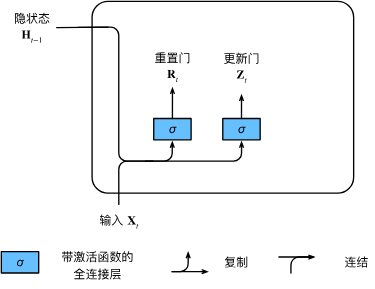
图9.1.1 在门控循环单元模型中计算重置门和更新门

我们来看一下门控循环单元的数学表达。
对于给定的时间步$t$，假设输入是一个小批量
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本个数$n$，输入个数$d$），
上一个时间步的隐状态是
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$
（隐藏单元个数$h$）。
那么，重置门$\mathbf{R}_t \in \mathbb{R}^{n \times h}$和
更新门$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$的计算如下所示：

<span id='eq.9.1.1'></span>
$$ \begin{align}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{align} \tag{9.1.1}$$

其中$\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$是偏置参数。
请注意，在求和过程中会触发广播机制
（请参阅[2.1.3节](./02.preliminaries.ipynb#广播机制)）。
我们使用sigmoid函数（如[4.1节](./04.multilayer-perceptrons.ipynb#多层感知机)中介绍的）
将输入值转换到区间$(0, 1)$。

#### 候选隐状态

接下来，让我们将重置门$\mathbf{R}_t$
与([8.4.5](./08.recurrent-neural-networks.ipynb#eq.8.4.5))中的常规隐状态更新机制集成，
得到在时间步$t$的*候选隐状态*（candidate hidden state）
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$。

<span id='eq.9.1.2'></span>
$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h), \tag{9.1.2}$$

其中$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置项，
符号$\odot$是Hadamard积（按元素乘积）运算符。
在这里，我们使用tanh非线性激活函数来确保候选隐状态中的值保持在区间$(-1, 1)$中。

与([8.4.5](./08.recurrent-neural-networks.ipynb#eq.8.4.5))相比，
([9.1.2](#eq.9.1.2))中的<font color="red">$\mathbf{R}_t$和$\mathbf{H}_{t-1}$
的元素相乘可以减少以往状态的影响</font>。
<font color="blue">每当重置门$\mathbf{R}_t$中的项接近$1$时，
我们恢复一个如([8.4.5](./08.recurrent-neural-networks.ipynb#eq.8.4.5))中的普通的循环神经网络。
对于重置门$\mathbf{R}_t$中所有接近$0$的项，
候选隐状态是以$\mathbf{X}_t$作为输入的多层感知机的结果</font>。
因此，任何预先存在的隐状态都会被*重置*为默认值。

[图9.1.2](#fig.9.1.2)说明了应用重置门之后的计算流程。
<span id='fig.9.1.2'></span>
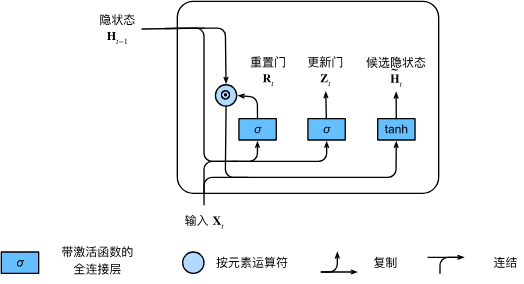
图9.1.2 在门控循环单元模型中计算候选隐状态

#### 隐状态

上述的计算结果只是候选隐状态，我们仍然需要结合更新门$\mathbf{Z}_t$的效果。
这一步确定新的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$
在多大程度上来自旧的状态$\mathbf{H}_{t-1}$和
新的候选状态$\tilde{\mathbf{H}}_t$。
更新门$\mathbf{Z}_t$仅需要在
$\mathbf{H}_{t-1}$和$\tilde{\mathbf{H}}_t$
之间进行按元素的凸组合就可以实现这个目标。
这就得出了门控循环单元的最终更新公式：

<span id='eq.9.1.3'></span>
$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t. \tag{9.1.3}$$

<font color="blue">每当更新门$\mathbf{Z}_t$接近$1$时，模型就倾向只保留旧状态。
此时，来自$\mathbf{X}_t$的信息基本上被忽略，
从而有效地跳过了依赖链条中的时间步$t$。
相反，当$\mathbf{Z}_t$接近$0$时，
新的隐状态$\mathbf{H}_t$就会接近候选隐状态$\tilde{\mathbf{H}}_t$</font>。
这些设计可以帮助我们<font color="red">处理循环神经网络中的梯度消失问题，
并更好地捕获时间步距离很长的序列的依赖关系</font>。
例如，如果整个子序列的所有时间步的更新门都接近于$1$，
则无论序列的长度如何，在序列起始时间步的旧隐状态都将很容易保留并传递到序列结束。

[图9.1.3](#fig.9.1.3)说明了更新门起作用后的计算流。
<span id='fig.9.1.3'></span>
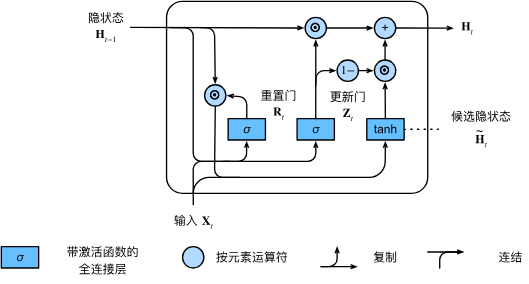
图9.1.3 计算门控循环单元模型中的隐状态

总之，门控循环单元具有以下两个显著特征：
* <font color="red">重置门有助于捕获序列中的短期依赖关系；</font>
* <font color="red">更新门有助于捕获序列中的长期依赖关系。</font>

### 从零开始实现

为了更好地理解门控循环单元模型，我们从零开始实现它。
首先，我们读取[8.5节](./08.recurrent-neural-networks.ipynb#循环神经网络的从零开始实现)中使用的时间机器数据集：

In [ ]:
import torch
from torch import nn
import os, hashlib, requests, re

# source: 8.2.1. 读取数据集
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

# source: 8.2.2. 词元化
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
        
# source: 8.2.3. 词表
import collections
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = self.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break # 前面有排序, 词频从大到小排序, 也就是当出现第一个词频小于min_freq时, 后面的全部会小于min_freq
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

    def count_corpus(self, tokens):
        """统计词元的频率"""
        # 这里的tokens是1D列表或2D列表
        if len(tokens) == 0 or isinstance(tokens[0], list):
            # 将词元列表展平成一个列表
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens) 

# 2. 构建数据迭代器和词表
# source: 8.2.4. 整合所有功能
import random, torch
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()      # 读取数据集
    tokens = tokenize(lines, 'char') # 词元化
    vocab = Vocab(tokens)            # 词表
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    
    """
    corpus2 = []
    for index, line in enumerate(tokens):
        for token in line:
            corpus2.append(vocab[token])
    assert(corpus == corpus2)
    """
    
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

# source: 8.3.4.1. 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

# source: 8.3.4.2. 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random     # 随机采样
        else:
            self.data_iter_fn = seq_data_iter_sequential # 顺序分区
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps) # train_iter: feature-label迭代器; vocab: 词表

In [ ]:
print(vocab._token_freqs)

In [ ]:
print(vocab.idx_to_token)

In [ ]:
print(vocab.token_to_idx)

#### 初始化模型参数

下一步是初始化模型参数。
我们从标准差为$0.01$的高斯分布中提取权重，
并将偏置项设为$0$，超参数`num_hiddens`定义隐藏单元的数量，
实例化与更新门、重置门、候选隐状态和输出层相关的所有权重和偏置。

In [ ]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#### 定义模型

现在我们将定义隐状态的初始化函数`init_gru_state`。
与[8.5节](./08.recurrent-neural-networks.ipynb#循环神经网络的从零开始实现)中定义的`init_rnn_state`函数一样，
此函数返回一个形状为（批量大小，隐藏单元个数）的张量，张量的值全部为零。

In [ ]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

现在我们准备定义门控循环单元模型，
模型的架构与基本的循环神经网络单元是相同的，
只是权重更新公式更为复杂。

In [ ]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

> note:
$$ \begin{align}
\mathbf{R}_{t \left[n \times h\right]} & = \sigma(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xr \left[d \times h\right]} + \mathbf{H}_{t-1 \left[n \times h\right]} \mathbf{W}_{hr \left[h \times h\right]} + \mathbf{b}_{r \left[1 \times h\right]}), \tag{9.1.1}\\
\mathbf{Z}_{t \left[n \times h\right]} & = \sigma(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xz \left[d \times h\right]} + \mathbf{H}_{t-1 \left[n \times h\right]} \mathbf{W}_{hz \left[h \times h\right]} + \mathbf{b}_{z \left[1 \times h\right]}), \\
\tilde{\mathbf{H}}_{t \left[n \times h\right]} & = \tanh(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xh \left[d \times h\right]} + \left(\mathbf{R}_{t \left[n \times h\right]} \odot \mathbf{H}_{t-1 \left[n \times h\right]}\right) \mathbf{W}_{hh \left[h \times h\right]} + \mathbf{b}_{h \left[1 \times h\right]}), \tag{9.1.2} \\
\mathbf{H}_{t \left[n \times h\right]} & = \mathbf{Z}_{t \left[n \times h\right]} \odot \mathbf{H}_{t-1 \left[n \times h\right]}  + (1 - \mathbf{Z}_{t \left[n \times h\right]}) \odot \tilde{\mathbf{H}}_{t \left[n \times h\right]}. \tag{9.1.3}
\end{align}$$
$\mathbf{R}_t \in \mathbb{R}^{n \times h}$是重置门;  
$\mathbf{Z}_t \in \mathbb{R}^{n \times h}$是更新门;  
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$是在时间步$t$的*候选隐状态*(candidate hidden state);  
$\mathbf{H}_t \in \mathbb{R}^{n \times h}$是新的隐状态;  
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$是小批量输入(样本个数$n$, 输入个数$d$);  
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$是上一个时间步的隐状态(隐藏单元个数$h$);  
$\mathbf{W}_{xr}, \mathbf{W}_{xz}, \mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hr}, \mathbf{W}_{hz}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$是权重参数;  
$\mathbf{b}_r, \mathbf{b}_z, \mathbf{b}_h \in \mathbb{R}^{1 \times h}$是偏置参数;  
$\sigma$是sigmoid函数, 将输入值转换到区间$(0, 1)$;  
$\odot$是Hadamard积(按元素乘积)运算符;  
$\tanh$非线性激活函数确保候选隐状态中的值保持在区间$(-1, 1)$中。
          


#### 训练与预测

训练和预测的工作方式与[8.5节](./08.recurrent-neural-networks.ipynb#循环神经网络的从零开始实现)完全相同。
训练结束后，我们分别打印输出训练集的困惑度，
以及前缀“time traveler”和“traveler”的预测序列上的困惑度。

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):                                           # 输入X的形状: (批量大小, 时间步数量)
        X = nn.functional.one_hot(X.T, self.vocab_size).type(torch.float32) # 此时, X的形状: (时间步数量, 批量大小, 词表大小)
        return self.forward_fn(X, state, self.params)                       # 执行 rnn()

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
# source: 8.5.4. 预测
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state) # 更新隐状态
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# source: 8.5.5. 梯度裁剪
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum( torch.sum((p.grad ** 2)) for p in params ))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# source: 8.5.6. 训练
import time, numpy, math
class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return numpy.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期"""
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        # 隐状态
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        
        # y shape = (时间步数 × 批量大小)
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        
        # X shape = (批量大小/batch_size, 时间步数量/num_steps)
        # state[0] shape = (批量大小, 隐藏单元数)
        # y_hat shape = (时间步数 × 批量大小, 词表大小)
        y_hat, state = net(X, state)     # 神经网络
        
        l = loss(y_hat, y.long()).mean() # 损失函数
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()                 # 反向传播
            grad_clipping(net, 1)        # 梯度裁剪
            updater.step()               # 优化
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    # metric[0]: 累积训练损失之和
    # metric[1]: 累积已训练词元数量
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent.

    Defined in :numref:`sec_linear_scratch`"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        # if (epoch + 1) % 10 == 0:
        #     print(predict('time traveller'))
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)

num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 简洁实现

高级API包含了前文介绍的所有配置细节，
所以我们可以直接实例化门控循环单元模型。
这段代码的运行速度要快得多，
因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。

In [ ]:
# source: 8.6.1. 定义模型
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state): # 相当于 class RNNModelScratch 类中的 __call__()
        X = nn.functional.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 小结

* 门控循环神经网络可以更好地捕获时间步距离很长的序列上的依赖关系。
* <font color="red">重置门有助于捕获序列中的短期依赖关系</font>。
* <font color="red">更新门有助于捕获序列中的长期依赖关系</font>。
* 重置门打开时，门控循环单元包含基本循环神经网络；更新门打开时，门控循环单元可以跳过子序列。

## 长短期记忆网络（LSTM）

长期以来，隐变量模型存在着长期信息保存和短期输入缺失的问题。
解决这一问题的最早方法之一是长短期存储器（long short-term memory，LSTM）([Hochreiter and Schmidhuber, 1997](#paper.Hochreiter.1997.2))。
它有许多与门控循环单元（[9.1节](# 门控循环单元（GRU）)）一样的属性。
有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些，
却比门控循环单元早诞生了近20年。

> - <span id='paper.Hochreiter.1997.2'></span> Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735–1780.

### 门控记忆元

可以说，长短期记忆网络的设计灵感来自于计算机的逻辑门。
长短期记忆网络引入了*记忆元*（memory cell），或简称为*单元*（cell）。
有些文献认为记忆元是隐状态的一种特殊类型，
它们与隐状态具有相同的形状，其设计目的是用于记录附加的信息。
为了控制记忆元，我们需要许多门。
其中一个门用来从单元中输出条目，我们将其称为*输出门*（output gate）。
另外一个门用来决定何时将数据读入单元，我们将其称为*输入门*（input gate）。
我们还需要一种机制来重置单元的内容，由*遗忘门*（forget gate）来管理，
这种设计的动机与门控循环单元相同，
能够通过专用机制决定什么时候记忆或忽略隐状态中的输入。
让我们看看这在实践中是如何运作的。

#### 输入门、忘记门和输出门

就如在门控循环单元中一样，
当前时间步的输入和前一个时间步的隐状态
作为数据送入长短期记忆网络的门中，
如[图9.2.1](#fig.9.2.1)所示。
它们由三个具有sigmoid激活函数的全连接层处理，
以计算输入门、遗忘门和输出门的值。
因此，这三个门的值都在$(0, 1)$的范围内。

<span id='fig.9.2.1'></span>
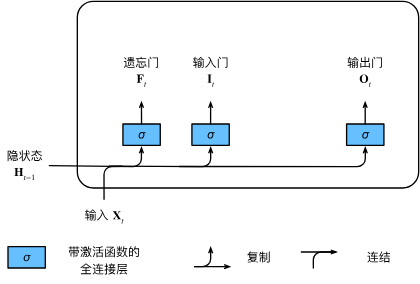
图9.2.1 长短期记忆模型中的输入门、遗忘门和输出门

我们来细化一下长短期记忆网络的数学表达。
假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。
因此，输入为$\mathbf{X}_t \in \mathbb{R}^{n \times d}$，
前一时间步的隐状态为$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。
相应地，时间步$t$的门被定义如下：
输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$，
遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$，
输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。
它们的计算方法如下：

<span id='eq.9.2.1'></span>
$$ \begin{align}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{align} \tag{9.2.1} $$

其中$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$
和$\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$是偏置参数。

#### 候选记忆元

由于还没有指定各种门的操作，所以先介绍*候选记忆元*（candidate memory cell）
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。
它的计算与上面描述的三个门的计算类似，
但是使用$\tanh$函数作为激活函数，函数的值范围为$(-1, 1)$。
下面导出在时间步$t$处的方程：

<span id='eq.9.2.2'></span>
$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c), \tag{9.2.2}$$

其中$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$和
$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，
$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数。

候选记忆元的如[图9.2.2](#fig.9.2.2)所示。

<span id='fig.9.2.2'></span>
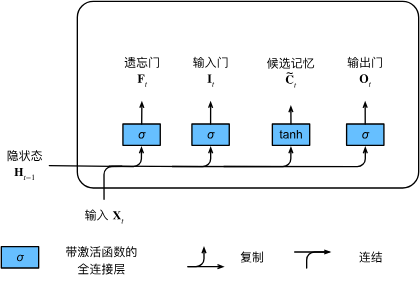
图9.2.2 长短期记忆模型中的候选记忆元

#### 记忆元

在门控循环单元中，有一种机制来控制输入和遗忘（或跳过）。
类似地，在长短期记忆网络中，也有两个门用于这样的目的：
输入门$\mathbf{I}_t$控制采用多少来自$\tilde{\mathbf{C}}_t$的新数据，
而遗忘门$\mathbf{F}_t$控制保留多少过去的
记忆元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。
使用按元素乘法，得出：

<span id='eq.9.2.3'></span>
$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t. \tag{9.2.3}$$

如果遗忘门始终为$1$且输入门始终为$0$，
则过去的记忆元$\mathbf{C}_{t-1}$
将随时间被保存并传递到当前时间步。
引入这种设计是为了缓解梯度消失问题，
并更好地捕获序列中的长距离依赖关系。

这样我们就得到了计算记忆元的流程图，如[图9.2.3](#fig.9.2.3)。

<span id='fig.9.2.3'></span>
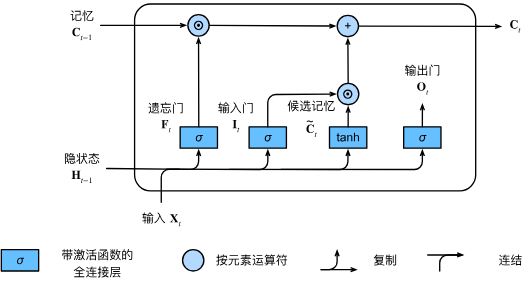
图9.2.3 在长短期记忆网络模型中计算记忆元

#### 隐状态

最后，我们需要定义如何计算隐状态
$\mathbf{H}_t \in \mathbb{R}^{n \times h}$，
这就是输出门发挥作用的地方。
在长短期记忆网络中，它仅仅是记忆元的$\tanh$的门控版本。
这就确保了$\mathbf{H}_t$的值始终在区间$(-1, 1)$内：

<span id='eq.9.2.4'></span>
$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t). \tag{9.2.4}$$

只要输出门接近$1$，我们就能够有效地将所有记忆信息传递给预测部分，
而对于输出门接近$0$，我们只保留记忆元内的所有信息，而不需要更新隐状态。

[图9.2.4](#fig.9.2.4)提供了数据流的图形化演示。

<span id='fig.9.2.4'></span>
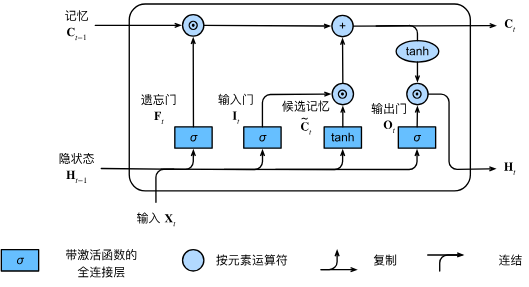
图9.2.4 在长短期记忆模型中计算隐状态

### 从零开始实现

现在，我们从零开始实现长短期记忆网络。
与[8.5节](./08.recurrent-neural-networks.ipynb#循环神经网络的从零开始实现)中的实验相同，我们首先加载时光机器数据集。

In [ ]:
import torch
from torch import nn

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps) # load_data_time_machine()定义在"9.1.2 从零开始实现"

#### 初始化模型参数

接下来，我们需要定义和初始化模型参数。
如前所述，超参数`num_hiddens`定义隐藏单元的数量。
我们按照标准差$0.01$的高斯分布初始化权重，并将偏置项设为$0$。

In [ ]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#### 定义模型

在初始化函数中，
长短期记忆网络的隐状态需要返回一个*额外*的记忆元，
单元的值为0，形状为（批量大小，隐藏单元数）。
因此，我们得到以下的状态初始化。

In [ ]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型的定义与我们前面讨论的一样：
提供三个门和一个额外的记忆元。
请注意，只有隐状态才会传递到输出层，
而记忆元$\mathbf{C}_t$不直接参与输出计算。

In [ ]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

> note:
$$ \begin{align}
\mathbf{I}_{t \left[n \times h\right]} & = \sigma(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xi \left[d \times h\right]} + \mathbf{H}_{t-1 \left[n \times h\right]} \mathbf{W}_{hi \left[h \times h\right]} + \mathbf{b}_{i \left[1 \times h\right]}), \tag{9.2.1} \\
\mathbf{F}_{t \left[n \times h\right]} & = \sigma(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xf \left[d \times h\right]} + \mathbf{H}_{t-1 \left[n \times h\right]} \mathbf{W}_{hf \left[h \times h\right]} + \mathbf{b}_{f \left[1 \times h\right]}),\\
\mathbf{O}_{t \left[n \times h\right]} & = \sigma(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xo \left[d \times h\right]} + \mathbf{H}_{t-1 \left[n \times h\right]} \mathbf{W}_{ho \left[h \times h\right]} + \mathbf{b}_{o \left[1 \times h\right]}), \\
\tilde{\mathbf{C}}_{t \left[n \times h\right]} & = \text{tanh}(\mathbf{X}_{t \left[n \times d\right]} \mathbf{W}_{xc \left[d \times h\right]} + \mathbf{H}_{t-1 \left[n \times h\right]} \mathbf{W}_{hc \left[h \times h\right]} + \mathbf{b}_{c \left[1 \times h\right]}), \tag{9.2.2} \\
\mathbf{C}_{t \left[n \times h\right]} & = \mathbf{F}_{t \left[n \times h\right]} \odot \mathbf{C}_{t-1 \left[n \times h\right]} + \mathbf{I}_{t \left[n \times h\right]} \odot \tilde{\mathbf{C}}_{t \left[n \times h\right]}. \tag{9.2.3} \\
\mathbf{H}_{t \left[n \times h\right]} & = \mathbf{O}_{t \left[n \times h\right]} \odot \tanh(\mathbf{C}_{t \left[n \times h\right]}). \tag{9.2.4}
\end{align} $$
$\mathbf{I}_t \in \mathbb{R}^{n \times h}$是输入门;  
$\mathbf{F}_t \in \mathbb{R}^{n \times h}$是遗忘门;  
$\mathbf{O}_t \in \mathbb{R}^{n \times h}$是输出门;  
$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$是*候选记忆元*(candidate memory cell), 使用$\tanh$函数作为激活函数，函数的值范围为$(-1, 1)$;  
$\mathbf{C}_{t} \in \mathbb{R}^{n \times h}$是$t$时刻的记忆元;  
$\mathbf{H}_t \in \mathbb{R}^{n \times h}$是隐状态, 其值始终在区间$(-1, 1)$内;  
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$是输入($n$是批量大小, $d$是输入数);  
$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$是前一时间步的隐状态($h$是隐藏单元数量);  
$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo}, \mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$ 和 $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho}, \mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数;  
$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o, \mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数.

#### 训练和预测

让我们通过实例化[8.5节](./08.recurrent-neural-networks.ipynb#循环神经网络的从零开始实现)中
引入的`RNNModelScratch`类来训练一个长短期记忆网络，
就如我们在[9.1节](#门控循环单元（GRU）)中所做的一样。

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
model = RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 简洁实现

使用高级API，我们可以直接实例化`LSTM`模型。
高级API封装了前文介绍的所有配置细节。
这段代码的运行速度要快得多，
因为它使用的是编译好的运算符而不是Python来处理之前阐述的许多细节。

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络是典型的具有重要状态控制的隐变量自回归模型。
多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。
然而，<font color="red">由于序列的长距离依赖性，训练长短期记忆网络
和其他序列模型（例如门控循环单元）的成本是相当高的。
在后面的内容中，我们将讲述更高级的替代模型，如Transformer</font>。

### 小结

* 长短期记忆网络有三种类型的门：输入门、遗忘门和输出门。
* 长短期记忆网络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，而记忆元完全属于内部信息。
* 长短期记忆网络可以缓解梯度消失和梯度爆炸。

## 深度循环神经网络

到目前为止，我们只讨论了具有一个单向隐藏层的循环神经网络。
其中，隐变量和观测值与具体的函数形式的交互方式是相当随意的。
只要交互类型建模具有足够的灵活性，这就不是一个大问题。
然而，对一个单层来说，这可能具有相当的挑战性。
之前在线性模型中，我们通过添加更多的层来解决这个问题。
而在循环神经网络中，我们首先需要确定如何添加更多的层，
以及在哪里添加额外的非线性，因此这个问题有点棘手。

事实上，我们可以将多层循环神经网络堆叠在一起，
通过对几个简单层的组合，产生了一个灵活的机制。
特别是，数据可能与不同层的堆叠有关。
例如，我们可能希望保持有关金融市场状况
（熊市或牛市）的宏观数据可用，
而微观数据只记录较短期的时间动态。

[图9.3.1](#fig.9.3.1)描述了一个具有$L$个隐藏层的深度循环神经网络，
每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步。

<span id='fig.9.3.1'></span>
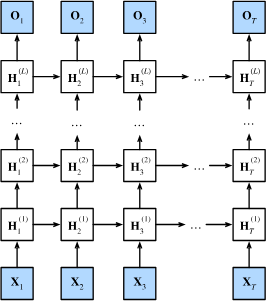
图9.3.1 深度循环神经网络结构

> note:<br>具有一个单向隐藏层的循环神经网络
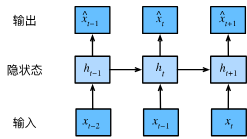
图8.1.2 隐变量自回归模型

### 函数依赖关系

我们可以将深度架构中的函数依赖关系形式化，
这个架构是由[图9.3.1](#fig.9.3.1)中描述了$L$个隐藏层构成。
后续的讨论主要集中在经典的循环神经网络模型上，
但是这些讨论也适应于其他序列模型。

假设在时间步$t$有一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数：$n$，每个样本中的输入数：$d$）。
同时，将$l^\mathrm{th}$隐藏层（$l=1,\ldots,L$）
的隐状态设为$\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$
（隐藏单元数：$h$），
输出层变量设为$\mathbf{O}_t \in \mathbb{R}^{n \times q}$
（输出数：$q$）。
设置$\mathbf{H}_t^{(0)} = \mathbf{X}_t$，
第$l$个隐藏层的隐状态使用激活函数$\phi_l$，则：

<span id='eq.9.3.1'></span>
$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}), \tag{9.3.1}$$

其中，权重$\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$，
$\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$和
偏置$\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$
都是第$l$个隐藏层的模型参数。

最后，输出层的计算仅基于第$l$个隐藏层最终的隐状态：

<span id='eq.9.3.2'></span>
$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q, \tag{9.3.2}$$

其中，权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$都是输出层的模型参数。

与多层感知机一样，隐藏层数目$L$和隐藏单元数目$h$都是超参数。
也就是说，它们可以由我们调整的。
另外，用门控循环单元或长短期记忆网络的隐状态
来代替([9.3.1](#eq.9.3.1))中的隐状态进行计算，
可以很容易地得到深度门控循环神经网络或深度长短期记忆神经网络。

### 简洁实现

实现多层循环神经网络所需的许多逻辑细节在高级API中都是现成的。
简单起见，我们仅示范使用此类内置函数的实现方式。
以长短期记忆网络模型为例，
该代码与之前在[9.2节](#长短期记忆网络（LSTM）)中使用的代码非常相似，
实际上唯一的区别是我们指定了层的数量，
而不是使用单一层这个默认值。
像往常一样，我们从加载数据集开始。

In [ ]:
import torch
from torch import nn

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

像选择超参数这类架构决策也跟[9.2节](#长短期记忆网络（LSTM）)中的决策非常相似。
因为我们有不同的词元，所以输入和输出都选择相同数量，即`vocab_size`。
隐藏单元的数量仍然是$256$。
唯一的区别是，我们现在通过`num_layers`的值来设定隐藏层数。

In [ ]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

### 训练与预测

由于使用了长短期记忆网络模型来实例化两个层，因此训练速度被大大降低了。

In [ ]:
num_epochs, lr = 500, 2
train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

### 小结

* 在深度循环神经网络中，隐状态的信息被传递到当前层的下一时间步和下一层的当前时间步。
* 有许多不同风格的深度循环神经网络，
  如长短期记忆网络、门控循环单元、或经典循环神经网络。
  这些模型在深度学习框架的高级API中都有涵盖。
* 总体而言，<font color="red">深度循环神经网络需要大量的调参（如学习率和修剪）
  来确保合适的收敛，模型的初始化也需要谨慎</font>。

## 双向循环神经网络

在序列学习中，我们以往假设的目标是：
在给定观测的情况下
（例如，在时间序列的上下文中或在语言模型的上下文中），
对下一个输出进行建模。
虽然这是一个典型情景，但不是唯一的。
还可能发生什么其它的情况呢？
我们考虑以下三个在文本序列中填空的任务。

* 我`___`。
* 我`___`饿了。
* 我`___`饿了，我可以吃半头猪。

根据可获得的信息量，我们可以用不同的词填空，
如“很高兴”（"happy"）、“不”（"not"）和“非常”（"very"）。
很明显，每个短语的“下文”传达了重要信息（如果有的话），
而这些信息关乎到选择哪个词来填空，
所以无法利用这一点的序列模型将在相关任务上表现不佳。
例如，如果要做好命名实体识别
（例如，识别“Green”指的是“格林先生”还是绿色），
不同长度的上下文范围重要性是相同的。
为了获得一些解决问题的灵感，让我们先迂回到概率图模型。

### 隐马尔可夫模型中的动态规划

这一小节是用来说明动态规划问题的，
具体的技术细节对于理解深度学习模型并不重要，
但它有助于我们思考为什么要使用深度学习，
以及为什么要选择特定的架构。

如果我们想用概率图模型来解决这个问题，
可以设计一个隐变量模型：
在任意时间步$t$，假设存在某个隐变量$h_t$，
通过概率$P(x_t \mid h_t)$控制我们观测到的$x_t$。
此外，任何$h_t \to h_{t+1}$转移
都是由一些状态转移概率$P(h_{t+1} \mid h_{t})$给出。
这个概率图模型就是一个*隐马尔可夫模型*（hidden Markov model，HMM），
如[图9.4.1](#fig.9.4.1)所示。

<span id='fig.9.4.1'></span>
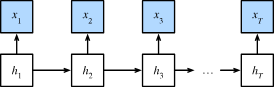
图9.4.1 隐马尔可夫模型

因此，对于有$T$个观测值的序列，
我们在观测状态和隐状态上具有以下联合概率分布：

<span id='eq.9.4.1'></span>
$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1). \tag{9.4.1}$$

现在，假设我们观测到所有的$x_i$，除了$x_j$，
并且我们的目标是计算$P(x_j \mid x_{-j})$，
其中$x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$。
由于$P(x_j \mid x_{-j})$中没有隐变量，
因此我们考虑对$h_1, \ldots, h_T$选择构成的
所有可能的组合进行求和。
如果任何$h_i$可以接受$k$个不同的值（有限的状态数），
这意味着我们需要对$k^T$个项求和，
这个任务显然难于登天。
幸运的是，有个巧妙的解决方案：*动态规划*（dynamic programming）。

要了解动态规划的工作方式，
我们考虑对隐变量$h_1, \ldots, h_T$的依次求和。
根据([9.4.1](#eq.9.4.1))，将得出：

<span id='eq.9.4.2'></span>
$$ \tag{9.4.2} \begin{align}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{align} $$

通常，我们将*前向递归*（forward recursion）写为：

<span id='eq.9.4.3'></span>
$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t). \tag{9.4.3}$$

递归被初始化为$\pi_1(h_1) = P(h_1)$。
符号简化，也可以写成$\pi_{t+1} = f(\pi_t, x_t)$，
其中$f$是一些可学习的函数。
这看起来就像我们在循环神经网络中讨论的隐变量模型中的更新方程。

与前向递归一样，我们也可以使用后向递归对同一组隐变量求和。这将得到：

<span id='eq.9.4.4'></span>
$$ \tag{9.4.4} \begin{align}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{align} $$

因此，我们可以将*后向递归*（backward recursion）写为：

<span id='eq.9.4.5'></span>
$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}), \tag{9.4.5}$$

初始化$\rho_T(h_T) = 1$。
前向和后向递归都允许我们对$T$个隐变量在$\mathcal{O}(kT)$
（线性而不是指数）时间内对$(h_1, \ldots, h_T)$的所有值求和。
这是使用图模型进行概率推理的巨大好处之一。
它也是通用消息传递算法([Aji and McEliece, 2000](#paper.Aji.2000))的一个非常特殊的例子。
结合前向和后向递归，我们能够计算

<span id='eq.9.4.6'></span>
$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j). \tag{9.4.6}$$

因为符号简化的需要，后向递归也可以写为$\rho_{t-1} = g(\rho_t, x_t)$，
其中$g$是一个可以学习的函数。
同样，这看起来非常像一个更新方程，
只是不像我们在循环神经网络中看到的那样前向运算，而是后向计算。
事实上，<font color="red">知道未来数据何时可用</font>对隐马尔可夫模型是有益的。
信号处理学家将是否知道未来观测这两种情况区分为内插和外推，
有关更多详细信息，请参阅([Doucet et al., 2001](#paper.Doucet.2001))。

> - <span id='paper.Aji.2000'></span> Aji, S. M., & McEliece, R. J. (2000). The generalized distributive law. IEEE transactions on Information Theory, 46(2), 325–343.
> - <span id='paper.Doucet.2001'></span> Doucet, A., De Freitas, N., & Gordon, N. (2001). An introduction to sequential monte carlo methods. Sequential Monte Carlo methods in practice (pp. 3–14). Springer.

### 双向模型

如果我们希望在循环神经网络中拥有一种机制，
使之能够提供与隐马尔可夫模型类似的<font color="red">前瞻能力</font>，
我们就需要修改循环神经网络的设计。
幸运的是，这在概念上很容易，
只需要增加一个“从最后一个词元开始从后向前运行”的循环神经网络，
而不是只有一个在前向模式下“从第一个词元开始运行”的循环神经网络。
<font color="red">双向循环神经网络*（bidirectional RNNs）
添加了反向传递信息的隐藏层</font>，以便更灵活地处理此类信息。
[图9.4.2](#fig.9.4.2)描述了具有单个隐藏层的双向循环神经网络的架构。

<span id='fig.9.4.2'></span>
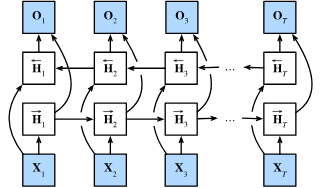
图9.4.2 双向循环神经网络架构

事实上，这与隐马尔可夫模型中的动态规划的前向和后向递归没有太大区别。
其主要区别是，在隐马尔可夫模型中的方程具有特定的统计意义。
双向循环神经网络没有这样容易理解的解释，
我们只能把它们当作通用的、可学习的函数。
这种转变集中体现了现代深度网络的设计原则：
首先使用经典统计模型的函数依赖类型，然后将其参数化为通用形式。

#### 定义

双向循环神经网络是由([Schuster and Paliwal, 1997](#paper.Schuster.1997))提出的，
关于各种架构的详细讨论请参阅([Graves and Schmidhuber, 2005](#paper.Graves.2005))。
让我们看看这样一个网络的细节。

> - <span id='paper.Schuster.1997'></span> Schuster, M., & Paliwal, K. K. (1997). Bidirectional recurrent neural networks. IEEE Transactions on Signal Processing, 45(11), 2673–2681.
> - <span id='paper.Graves.2005'></span> Graves, A., & Schmidhuber, J. (2005). Framewise phoneme classification with bidirectional lstm and other neural network architectures. Neural networks, 18(5-6), 602–610.

对于任意时间步$t$，给定一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数$n$，每个示例中的输入数$d$），
并且令隐藏层激活函数为$\phi$。
在双向架构中，我们设该时间步的前向和反向隐状态分别为
$\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$和
$\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，
其中$h$是隐藏单元的数目。
前向和反向隐状态的更新如下：

<span id='eq.9.4.7'></span>
$$ \tag{9.4.7} \begin{align}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{align} $$

其中，权重$\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$
和偏置$\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$都是模型参数。

接下来，将前向隐状态$\overrightarrow{\mathbf{H}}_t$
和反向隐状态$\overleftarrow{\mathbf{H}}_t$连接起来，
获得需要送入输出层的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$。
在具有多个隐藏层的深度双向循环神经网络中，
该信息作为输入传递到下一个双向层。
最后，输出层计算得到的输出为
$\mathbf{O}_t \in \mathbb{R}^{n \times q}$（$q$是输出单元的数目）：

<span id='eq.9.4.8'></span>
$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q. \tag{9.4.8}$$

这里，权重矩阵$\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$
是输出层的模型参数。
事实上，这两个方向可以拥有不同数量的隐藏单元。

#### 模型的计算代价及其应用

双向循环神经网络的一个关键特性是：<font color="red">使用来自序列两端的信息来估计输出</font>。
也就是说，我们<font color="red">使用来自过去和未来的观测信息来预测当前的观测</font>。
但是在对下一个词元进行预测的情况中，这样的模型并不是我们所需的。
因为<font color="blue">在预测下一个词元时，我们终究无法知道下一个词元的下文是什么，
所以将不会得到很好的精度</font>。
具体地说，<font color="blue">在训练期间，我们能够利用过去和未来的数据来估计现在空缺的词；
而在测试期间，我们只有过去的数据，因此精度将会很差<blue>。
下面的实验将说明这一点。

另一个严重问题是，双向循环神经网络的<font color="blue">计算速度非常慢</font>。
其主要原因是网络的前向传播需要在双向层中进行前向和后向递归，
并且网络的反向传播还依赖于前向传播的结果。
因此，<font color="blue">梯度求解将有一个非常长的链</font>。

双向层的使用在实践中非常少，并且<font color="red">仅仅应用于部分场合。
例如，填充缺失的单词、词元注释（例如，用于命名实体识别）
以及作为序列处理流水线中的一个步骤对序列进行编码（例如，用于机器翻译）</font>。
在[14.8节](./14.natural-language-processing-pretraining.ipynb#来自Transformers的双向编码器表示（BERT）)和[15.2节](./15.natural-language-processing-applications.ipynb#情感分析：使用循环神经网络)中，
我们将介绍如何使用双向循环神经网络编码文本序列。

### 双向循环神经网络的错误应用

由于双向循环神经网络使用了过去的和未来的数据，
所以我们不能盲目地将这一语言模型应用于任何预测任务。
尽管模型产出的困惑度是合理的，
该模型预测未来词元的能力却可能存在严重缺陷。
我们用下面的示例代码引以为戒，以防在错误的环境中使用它们。

In [ ]:
import torch
from torch import nn

# 加载数据
batch_size, num_steps, device = 32, 35, try_gpu()
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

上述结果显然令人瞠目结舌。
关于如何更有效地使用双向循环神经网络的讨论，
请参阅[15.2节](./15.natural-language-processing-applications.ipynb#情感分析：使用循环神经网络)中的情感分类应用。

### 小结

* 在双向循环神经网络中，每个时间步的隐状态由当前时间步的前后数据同时决定。
* 双向循环神经网络与概率图模型中的“前向-后向”算法具有相似性。
* 双向循环神经网络主要用于序列编码和给定双向上下文的观测估计。
* 由于梯度链更长，因此双向循环神经网络的训练代价非常高。

## 机器翻译与数据集

语言模型是自然语言处理的关键，
而*机器翻译*是语言模型最成功的基准测试。
因为机器翻译正是将输入序列转换成输出序列的
*序列转换模型*（sequence transduction）的核心问题。
序列转换模型在各类现代人工智能应用中发挥着至关重要的作用，
因此我们将其做为本章剩余部分和[10节](./10.attention-mechanisms.ipynb)的重点。
为此，本节将介绍机器翻译问题及其后文需要使用的数据集。

*机器翻译*（machine translation）指的是
将序列从一种语言自动翻译成另一种语言。
事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代，
特别是在第二次世界大战中使用计算机破解语言编码。
几十年来，在使用神经网络进行端到端学习的兴起之前，
统计学方法在这一领域一直占据主导地位([Brown et al., 1990](#paper.Brown.1990), [Brown et al., 1988](#paper.Brown.1988))。
因为*统计机器翻译*（statistical machine translation）涉及了
翻译模型和语言模型等组成部分的统计分析，
因此基于神经网络的方法通常被称为
*神经机器翻译*（neural machine translation），
用于将两种翻译模型区分开来。

> - <span id='paper.Brown.1990'></span> Brown, P. F., Cocke, J., Della Pietra, S. A., Della Pietra, V. J., Jelinek, F., Lafferty, J., … Roossin, P. S. (1990). A statistical approach to machine translation. Computational linguistics, 16(2), 79–85.
> - <span id='paper.Brown.1988'></span> Brown, P. F., Cocke, J., Della Pietra, S. A., Della Pietra, V. J., Jelinek, F., Mercer, R. L., & Roossin, P. (1988). A statistical approach to language translation. Coling Budapest 1988 Volume 1: International Conference on Computational Linguistics.

本书的关注点是神经网络机器翻译方法，强调的是端到端的学习。
与[8.3节](./08.recurrent-neural-networks.ipynb#语言模型和数据集)中的语料库
是单一语言的语言模型问题存在不同，
机器翻译的数据集是由源语言和目标语言的文本序列对组成的。
因此，我们需要一种完全不同的方法来预处理机器翻译数据集，
而不是复用语言模型的预处理程序。
下面，我们看一下如何将预处理后的数据加载到小批量中用于训练。

In [ ]:
import torch, os, zipfile, tarfile, hashlib, requests, collections, math

### 下载和预处理数据集

首先，下载一个由[Tatoeba项目的双语句子对](http://www.manythings.org/anki/)
组成的“英－法”数据集，数据集中的每一行都是制表符分隔的文本序列对，
序列对由英文文本序列和翻译后的法语文本序列组成。
请注意，每个文本序列可以是一个句子，
也可以是包含多个句子的一个段落。
在这个将英语翻译成法语的机器翻译问题中，
英语是*源语言*（source language），
法语是*目标语言*（target language）。

In [ ]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

下载数据集后，原始文本数据需要经过几个预处理步骤。
例如，我们用空格代替*不间断空格*（non-breaking space），
使用小写字母替换大写字母，并在单词和标点符号之间插入空格。

In [ ]:
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

### 词元化

与[8.3节](./08.recurrent-neural-networks.ipynb#语言模型和数据集)中的字符级词元化不同，
在机器翻译中，我们更喜欢单词级词元化
（最先进的模型可能使用更高级的词元化技术）。
下面的`tokenize_nmt`函数对前`num_examples`个文本序列对进行词元，
其中每个词元要么是一个词，要么是一个标点符号。
此函数返回两个词元列表：`source`和`target`：
`source[i]`是源语言（这里是英语）第$i$个文本序列的词元列表，
`target[i]`是目标语言（这里是法语）第$i$个文本序列的词元列表。

In [ ]:
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

让我们绘制每个文本序列所包含的词元数量的直方图。
在这个简单的“英－法”数据集中，大多数文本序列的词元数量少于$20$个。

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    backend_inline.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

In [ ]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    set_figsize()
    _, _, patches = plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', source, target);

### 词表

由于机器翻译数据集由语言对组成，
因此我们可以分别为源语言和目标语言构建两个词表。
使用单词级词元化时，词表大小将明显大于使用字符级词元化时的词表大小。
为了缓解这一问题，这里我们将出现次数少于2次的低频率词元
视为相同的未知（“&lt;unk&gt;”）词元。
除此之外，我们还指定了额外的特定词元，
例如在小批量时用于将序列填充到相同长度的填充词元（“&lt;pad&gt;”），
以及序列的开始词元（“&lt;bos&gt;”）和结束词元（“&lt;eos&gt;”）。
这些特殊词元在自然语言处理任务中比较常用。

In [ ]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = self.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break # 前面有排序, 词频从大到小排序, 也就是当出现第一个词频小于min_freq时, 后面的全部会小于min_freq
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

    def count_corpus(self, tokens):
        """统计词元的频率"""
        # 这里的tokens是1D列表或2D列表
        if len(tokens) == 0 or isinstance(tokens[0], list):
            # 将词元列表展平成一个列表
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)

In [ ]:
src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

### 加载数据集

回想一下，语言模型中的序列样本都有一个固定的长度，
无论这个样本是一个句子的一部分还是跨越了多个句子的一个片断。
这个固定长度是由[8.3节](./08.recurrent-neural-networks.ipynb#语言模型和数据集)中的
`num_steps`（时间步数或词元数量）参数指定的。
在机器翻译中，每个样本都是由源和目标组成的文本序列对，
其中的每个文本序列可能具有不同的长度。

为了提高计算效率，我们仍然可以通过*截断*（truncation）和
*填充*（padding）方式实现一次只处理一个小批量的文本序列。
假设同一个小批量中的每个序列都应该具有相同的长度`num_steps`，
那么如果文本序列的词元数目少于`num_steps`时，
我们将继续在其末尾添加特定的“&lt;pad&gt;”词元，
直到其长度达到`num_steps`；
反之，我们将截断文本序列时，只取其前`num_steps` 个词元，
并且丢弃剩余的词元。这样，每个文本序列将具有相同的长度，
以便以相同形状的小批量进行加载。

如前所述，下面的`truncate_pad`函数将截断或填充文本序列。

In [ ]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

现在我们定义一个函数，可以将文本序列
转换成小批量数据集用于训练。
我们将特定的“&lt;eos&gt;”词元添加到所有序列的末尾，
用于表示序列的结束。
当模型通过一个词元接一个词元地生成序列进行预测时，
生成的“&lt;eos&gt;”词元说明完成了序列输出工作。
此外，我们还记录了每个文本序列的长度，
统计长度时排除了填充词元，
在稍后将要介绍的一些模型会需要这个长度信息。

In [ ]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

### 训练模型

最后，我们定义`load_data_nmt`函数来返回数据迭代器，
以及源语言和目标语言的两种词表。

In [ ]:
from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

下面我们读出“英语－法语”数据集中的第一个小批量数据。

In [ ]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

### 小结

* 机器翻译指的是将文本序列从一种语言自动翻译成另一种语言。
* 使用单词级词元化时的词表大小，将明显大于使用字符级词元化时的词表大小。为了缓解这一问题，我们可以将低频词元视为相同的未知词元。
* 通过截断和填充文本序列，可以保证所有的文本序列都具有相同的长度，以便以小批量的方式加载。

## 编码器-解码器架构

正如我们在[9.5节](#机器翻译与数据集)中所讨论的，
机器翻译是序列转换模型的一个核心问题，
其输入和输出都是长度可变的序列。
为了处理这种类型的输入和输出，
我们可以设计一个包含两个主要组件的架构：
第一个组件是一个*编码器*（encoder）：
它接受一个长度可变的序列作为输入，
并将其转换为具有固定形状的编码状态。
第二个组件是*解码器*（decoder）：
它将固定形状的编码状态映射到长度可变的序列。
这被称为*编码器-解码器*（encoder-decoder）架构，
如[图9.6.1](#fig.9.6.1)所示。

<span id='fig.9.6.1'></span>
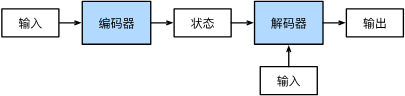
图9.6.1 编码器-解码器架构

我们以英语到法语的机器翻译为例：
给定一个英文的输入序列：“They”“are”“watching”“.”。
首先，这种“编码器－解码器”架构将长度可变的输入序列编码成一个“状态”，
然后对该状态进行解码，
一个词元接着一个词元地生成翻译后的序列作为输出：
“Ils”“regordent”“.”。
由于“编码器－解码器”架构是形成后续章节中不同序列转换模型的基础，
因此本节将把这个架构转换为接口方便后面的代码实现。

### 编码器

在编码器接口中，我们只指定长度可变的序列作为编码器的输入`X`。
任何继承这个`Encoder`基类的模型将完成代码实现。

In [ ]:
from torch import nn

class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

### 解码器

在下面的解码器接口中，我们新增一个<font color="red">`init_state`函数，
用于将编码器的输出（`enc_outputs`）转换为编码后的状态</font>。
注意，此步骤可能需要额外的输入，例如：输入序列的有效长度，
这在[9.5.4节](#加载数据集)中进行了解释。
为了逐个地生成长度可变的词元序列，
<font color="red">解码器在每个时间步都会将输入
（例如：在前一时间步生成的词元）和编码后的状态
映射成当前时间步的输出词元</font>。

In [ ]:
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

### 合并编码器和解码器

总而言之，“编码器-解码器”架构包含了一个编码器和一个解码器，
并且还拥有可选的额外的参数。
在前向传播中，<font color="red">编码器的输出用于生成编码状态，
这个状态又被解码器作为其输入的一部分</font>。

In [ ]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

“编码器－解码器”体系架构中的术语*状态*
会启发人们使用具有状态的神经网络来实现该架构。
在下一节中，我们将学习如何应用循环神经网络，
来设计基于“编码器－解码器”架构的序列转换模型。

### 小结

* “编码器－解码器”架构可以将长度可变的序列作为输入和输出，因此适用于机器翻译等序列转换问题。
* 编码器将长度可变的序列作为输入，并将其转换为具有固定形状的编码状态。
* 解码器将具有固定形状的编码状态映射为长度可变的序列。

##  序列到序列学习（seq2seq）

正如我们在[9.5节](#机器翻译与数据集)中看到的，
机器翻译中的输入序列和输出序列都是长度可变的。
为了解决这类问题，我们在[9.6节](#编码器-解码器架构)中
设计了一个通用的”编码器－解码器“架构。
本节，我们将使用两个循环神经网络的编码器和解码器，
并将其应用于*序列到序列*（sequence to sequence，seq2seq）类的学习任务([Cho et al., 2014](#paper.Cho.2014), [Sutskever et al., 2014](#paper.Sutskever.2014))。

遵循编码器－解码器架构的设计原则，
循环神经网络编码器使用长度可变的序列作为输入，
将其转换为固定形状的隐状态。
换言之，输入序列的信息被*编码*到循环神经网络编码器的隐状态中。
为了连续生成输出序列的词元，
独立的循环神经网络解码器是基于输入序列的编码信息
和输出序列已经看见的或者生成的词元来预测下一个词元。
[图9.7.1](#fig.9.7.1)演示了
如何在机器翻译中使用两个循环神经网络进行序列到序列学习。

<span id='fig.9.7.1'></span>
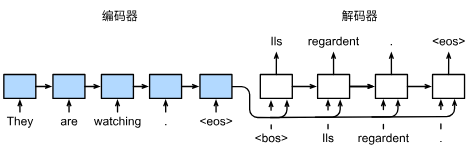
图9.7.1 使用循环神经网络编码器和循环神经网络解码器的序列到序列学习

在[图9.7.1](#fig.9.7.1)中，
特定的“&lt;eos&gt;”表示序列结束词元。
一旦输出序列生成此词元，模型就会停止预测。
在循环神经网络解码器的初始化时间步，有两个特定的设计决定：
首先，特定的“&lt;bos&gt;”表示序列开始词元，它是解码器的输入序列的第一个词元。
其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。
例如，在([Sutskever et al., 2014](#paper.Sutskever.2014))的设计中，
正是基于这种设计将输入序列的编码信息送入到解码器中来生成输出序列的。
在其他一些设计中([Cho et al., 2014](#paper.Cho.2014))，
如[图9.7.1](#fig.9.7.1)所示，
编码器最终的隐状态在每一个时间步都作为解码器的输入序列的一部分。
类似于[8.3节](./08.recurrent-neural-networks.ipynb#语言模型和数据集)中语言模型的训练，
可以允许标签成为原始的输出序列，
从源序列词元“&lt;bos&gt;”“Ils”“regardent”“.”
到新序列词元
“Ils”“regardent”“.”“&lt;eos&gt;”来移动预测的位置。

> - <span id='paper.Sutskever.2014'></span> Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. Advances in neural information processing systems (pp. 3104–3112).
> - <span id='paper.Cho.2014'></span> Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning phrase representations using rnn encoder-decoder for statistical machine translation. arXiv preprint arXiv:1406.1078.

下面，我们动手构建[图9.7.1](#fig.9.7.1)的设计，
并将基于[9.5节](#机器翻译与数据集)中
介绍的“英－法”数据集来训练这个机器翻译模型。

In [ ]:
import collections
import math
import torch
from torch import nn

### 编码器

从技术上讲，编码器将长度可变的输入序列转换成
形状固定的上下文变量$\mathbf{c}$，
并且将输入序列的信息在该上下文变量中进行编码。
如[图9.7.1](#fig.9.7.1)所示，可以使用循环神经网络来设计编码器。

考虑由一个序列组成的样本（批量大小是$1$）。
假设输入序列是$x_1, \ldots, x_T$，
其中$x_t$是输入文本序列中的第$t$个词元。
在时间步$t$，循环神经网络将词元$x_t$的输入特征向量
$\mathbf{x}_t$和$\mathbf{h} _{t-1}$（即上一时间步的隐状态）
转换为$\mathbf{h}_t$（即当前步的隐状态）。
使用一个函数$f$来描述循环神经网络的循环层所做的变换：

<span id='eq.9.7.1'></span>
$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). \tag{9.7.1}$$

总之，编码器通过选定的函数$q$，
将所有时间步的隐状态转换为上下文变量：

<span id='eq.9.7.2'></span>
$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T). \tag{9.7.2}$$

比如，当选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$时
（就像[图9.7.1](#fig.9.7.1)中一样），
上下文变量仅仅是输入序列在最后时间步的隐状态$\mathbf{h}_T$。

到目前为止，我们使用的是一个单向循环神经网络来设计编码器，
其中隐状态只依赖于输入子序列，
这个子序列是由输入序列的开始位置到隐状态所在的时间步的位置
（包括隐状态所在的时间步）组成。
我们也可以使用双向循环神经网络构造编码器，
其中隐状态依赖于两个输入子序列，
两个子序列是由隐状态所在的时间步的位置之前的序列和之后的序列
（包括隐状态所在的时间步），
因此隐状态对整个序列的信息都进行了编码。

现在，让我们实现循环神经网络编码器。
注意，我们使用了*嵌入层*（embedding layer）
来获得输入序列中每个词元的特征向量。
嵌入层的权重是一个矩阵，
其行数等于输入词表的大小（`vocab_size`），
其列数等于特征向量的维度（`embed_size`）。
对于任意输入词元的索引$i$，
嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其特征向量。
另外，本文选择了一个多层门控循环单元来实现编码器。

In [ ]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

循环层返回变量的说明可以参考[8.6节](./08.recurrent-neural-networks.ipynb#循环神经网络的简洁实现)。

下面，我们实例化上述编码器的实现：
我们使用一个两层门控循环单元编码器，其隐藏单元数为$16$。
给定一小批量的输入序列`X`（批量大小为$4$，时间步为$7$）。
在完成所有时间步后，
最后一层的隐状态的输出是一个张量（`output`由编码器的循环层返回），
其形状为（时间步数，批量大小，隐藏单元数）。

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

由于这里使用的是门控循环单元，
所以在最后一个时间步的多层隐状态的形状是
（隐藏层的数量，批量大小，隐藏单元的数量）。
如果使用长短期记忆网络，`state`中还将包含记忆单元信息。

In [ ]:
state.shape

### 解码器

正如上文提到的，编码器输出的上下文变量$\mathbf{c}$
对整个输入序列$x_1, \ldots, x_T$进行编码。
来自训练数据集的输出序列$y_1, y_2, \ldots, y_{T'}$，
对于每个时间步$t'$（与输入序列或编码器的时间步$t$不同），
解码器输出$y_{t'}$的概率取决于先前的输出子序列
$y_1, \ldots, y_{t'-1}$和上下文变量$\mathbf{c}$，
即$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。

为了在序列上模型化这种条件概率，
我们可以使用另一个循环神经网络作为解码器。
在输出序列上的任意时间步$t^\prime$，
循环神经网络将来自上一时间步的输出$y_{t^\prime-1}$
和上下文变量$\mathbf{c}$作为其输入，
然后在当前时间步将它们和上一隐状态
$\mathbf{s}_{t^\prime-1}$转换为
隐状态$\mathbf{s}_{t^\prime}$。
因此，可以使用函数$g$来表示解码器的隐藏层的变换：

<span id='eq.9.7.3'></span>
$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}). \tag{9.7.3}$$

在获得解码器的隐状态之后，
我们可以使用输出层和softmax操作
来计算在时间步$t^\prime$时输出$y_{t^\prime}$的条件概率分布
$P(y_{t^\prime} \mid y_1, \ldots, y_{t^\prime-1}, \mathbf{c})$。

根据[图9.7.1](#fig.9.7.1)，当实现解码器时，
我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。
这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。
为了进一步包含经过编码的输入序列的信息，
上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。
为了预测输出词元的概率分布，
在循环神经网络解码器的最后一层使用全连接层来变换隐状态。

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

下面，我们用与前面提到的编码器中相同的超参数来实例化解码器。
如我们所见，解码器的输出形状变为（批量大小，时间步数，词表大小），
其中张量的最后一个维度存储预测的词元分布。

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

总之，上述循环神经网络“编码器－解码器”模型中的各层如[图9.7.2](#fig.9.7.2)所示。

<span id='fig.9.7.2'></span>
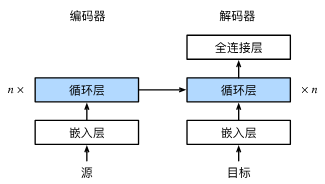
图9.7.2 循环神经网络编码器-解码器模型中的层

### 损失函数

在每个时间步，解码器预测了输出词元的概率分布。
类似于语言模型，可以使用softmax来获得分布，
并通过计算交叉熵损失函数来进行优化。
回想一下[9.5节](#机器翻译与数据集)中，
特定的填充词元被添加到序列的末尾，
因此不同长度的序列可以以相同形状的小批量加载。
但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的`sequence_mask`函数
通过零值化屏蔽不相关的项，
以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。
例如，如果两个序列的有效长度（不包括填充词元）分别为$1$和$2$，
则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

我们还可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项。

In [ ]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。
最初，所有预测词元的掩码都设置为1。
一旦给定了有效长度，与填充词元对应的掩码将被设置为0。
最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

我们可以创建三个相同的序列来进行代码健全性检查，
然后分别指定这些序列的有效长度为$4$、$2$和$0$。
结果就是，第一个序列的损失应为第二个序列的两倍，而第三个序列的损失应为零。

In [ ]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

### 训练

在下面的循环训练过程中，如[图9.7.1](#fig.9.7.1)所示，
特定的序列开始词元（“&lt;bos&gt;”）和
原始的输出序列（不包括序列结束词元“&lt;eos&gt;”）
拼接在一起作为解码器的输入。
这被称为*强制教学*（teacher forcing），
因为原始的输出序列（词元的标签）被送入解码器。
或者，将来自上一个时间步的*预测*得到的词元作为解码器的当前输入。

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

现在，在机器翻译数据集上，我们可以创建和训练一个循环神经网络“编码器－解码器”模型用于序列到序列的学习。

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### 预测

为了采用一个接着一个词元的方式预测输出序列，
每个解码器当前时间步的输入都将来自于前一时间步的预测词元。
与训练类似，序列开始词元（“&lt;bos&gt;”）
在初始时间步被输入到解码器中。
该预测过程如[图9.7.3](#fig.9.7.3)所示，
当输出序列的预测遇到序列结束词元（“&lt;eos&gt;”）时，预测就结束了。

<span id='fig.9.7.3'></span>
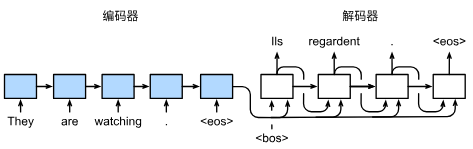
图9.7.3 使用循环神经网络编码器-解码器逐词元地预测输出序列。

我们将在[9.8节](#束搜索)中介绍不同的序列生成策略。

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

### 预测序列的评估

我们可以通过与真实的标签序列进行比较来评估预测序列。
虽然([Papineni et al., 2002](#paper.Papineni.2002))提出的BLEU（bilingual evaluation understudy）
最先是用于评估机器翻译的结果，
但现在它已经被广泛用于测量许多应用的输出序列的质量。
原则上说，对于预测序列中的任意$n$元语法（n-grams），
BLEU的评估都是这个$n$元语法是否出现在标签序列中。

> - <span id='paper.Papineni.2002'></span> Papineni, K., Roukos, S., Ward, T., & Zhu, W.-J. (2002). Bleu: a method for automatic evaluation of machine translation. Proceedings of the 40th annual meeting of the Association for Computational Linguistics (pp. 311–318).

我们将BLEU定义为：

<span id='eq.9.7.4'></span>
$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n}, \tag{9.7.4}$$

其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
第一个是预测序列与标签序列中匹配的$n$元语法的数量，
第二个是预测序列中$n$元语法的数量的比率。
具体地说，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$、$B$、$C$、$D$，
我们有$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$和$p_4 = 0$。

根据([9.7.4](#eq.9.7.4))中BLEU的定义，
当预测序列与标签序列完全相同时，BLEU为$1$。
此外，由于$n$元语法越长则匹配难度越大，
所以BLEU为更长的$n$元语法的精确度分配更大的权重。
具体来说，当$p_n$固定时，$p_n^{1/2^n}$
会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。
而且，由于预测的序列越短获得的$p_n$值越高，
所以([9.7.4](#eq.9.7.4))中乘法项之前的系数用于惩罚较短的预测序列。
例如，当$k=2$时，给定标签序列$A$、$B$、$C$、$D$、$E$、$F$
和预测序列$A$、$B$，尽管$p_1 = p_2 = 1$，
惩罚因子$\exp(1-6/2) \approx 0.14$会降低BLEU。

BLEU的代码实现如下。

In [ ]:
def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最后，利用训练好的循环神经网络“编码器－解码器”模型，将几个英语句子翻译成法语，并计算BLEU的最终结果。

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

### 小结

* 根据“编码器-解码器”架构的设计，
  我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。
* 在实现编码器和解码器时，我们可以使用多层循环神经网络。
* 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。
* 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。
* BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的$n$元语法的匹配度来评估预测。

## 束搜索

在[9.7节](#序列到序列学习（seq2seq）)中，我们逐个预测输出序列，
直到预测序列中出现特定的序列结束词元“&lt;eos&gt;”。
本节将首先介绍*贪心搜索*（greedy search）策略，
并探讨其存在的问题，然后对比其他替代策略：
*穷举搜索*（exhaustive search）和*束搜索*（beam search）。

在正式介绍贪心搜索之前，我们使用与[9.7节](#序列到序列学习（seq2seq）)中
相同的数学符号定义搜索问题。
在任意时间步$t'$，解码器输出$y_{t'}$的概率取决于
时间步$t'$之前的输出子序列$y_1, \ldots, y_{t'-1}$
和对输入序列的信息进行编码得到的上下文变量$\mathbf{c}$。
为了量化计算代价，用$\mathcal{Y}$表示输出词表，
其中包含“&lt;eos&gt;”，
所以这个词汇集合的基数$\left|\mathcal{Y}\right|$就是词表的大小。
我们还将输出序列的最大词元数指定为$T'$。
因此，我们的目标是从所有$\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$个
可能的输出序列中寻找理想的输出。
当然，对于所有输出序列，在“&lt;eos&gt;”之后的部分（非本句）
将在实际输出中丢弃。

### 贪心搜索

首先，让我们看看一个简单的策略：*贪心搜索*，
该策略已用于[9.7节](#序列到序列学习（seq2seq）)的序列预测。
对于输出序列的每一时间步$t'$，
我们都将基于贪心搜索从$\mathcal{Y}$中找到具有最高条件概率的词元，即：

<span id='eq.9.8.1'></span>
$$y_{t'} = \operatorname*{argmax}_{y \in \mathcal{Y}} P(y \mid y_1, \ldots, y_{t'-1}, \mathbf{c}) \tag{9.8.1}$$

一旦输出序列包含了“&lt;eos&gt;”或者达到其最大长度$T'$，则输出完成。

<span id='fig.9.8.1'></span>
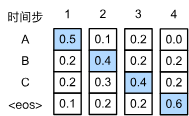
图9.8.1 在每个时间步，贪心搜索选择具有最高条件概率的词元

如[图9.8.1](#fig.9.8.1)中，
假设输出中有四个词元“A”“B”“C”和“&lt;eos&gt;”。
每个时间步下的四个数字分别表示在该时间步
生成“A”“B”“C”和“&lt;eos&gt;”的条件概率。
在每个时间步，贪心搜索选择具有最高条件概率的词元。
因此，将在[图9.8.1](#fig.9.8.1)中
预测输出序列“A”“B”“C”和“&lt;eos&gt;”。
这个输出序列的条件概率是
$0.5\times0.4\times0.4\times0.6 = 0.048$。

那么贪心搜索存在的问题是什么呢？
现实中，*最优序列*（optimal sequence）应该是最大化
$\prod_{t'=1}^{T'} P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$
值的输出序列，这是基于输入序列生成输出序列的条件概率。
然而，贪心搜索无法保证得到最优序列。

<span id='fig.9.8.2'></span>
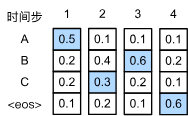
图9.8.2 在时间步2，选择具有第二高条件概率的词元"C"（而非最高条件概率的词元）

[图9.8.2](#fig.9.8.2)中的另一个例子阐述了这个问题。
与[图9.8.1](#fig.9.8.1)不同，在时间步$2$中，
我们选择[图9.8.2](#fig.9.8.2)中的词元“C”，
它具有*第二*高的条件概率。
由于时间步$3$所基于的时间步$1$和$2$处的输出子序列已从
[图9.8.1](#fig.9.8.1)中的“A”和“B”改变为
[图9.8.2](#fig.9.8.2)中的“A”和“C”，
因此时间步$3$处的每个词元的条件概率也在[图9.8.2](#fig.9.8.2)中改变。
假设我们在时间步$3$选择词元“B”，
于是当前的时间步$4$基于前三个时间步的输出子序列“A”“C”和“B”为条件，
这与[图9.8.1](#fig.9.8.1)中的“A”“B”和“C”不同。
因此，在[图9.8.2](#fig.9.8.2)中的时间步$4$生成
每个词元的条件概率也不同于[图9.8.1](#fig.9.8.1)中的条件概率。
结果，[图9.8.2](#fig.9.8.2)中的输出序列
“A”“C”“B”和“&lt;eos&gt;”的条件概率为
$0.5\times0.3 \times0.6\times0.6=0.054$，
这大于[图9.8.1](#fig.9.8.1)中的贪心搜索的条件概率。
这个例子说明：贪心搜索获得的输出序列
“A”“B”“C”和“&lt;eos&gt;”
不一定是最佳序列。

### 穷举搜索

如果目标是获得最优序列，
我们可以考虑使用*穷举搜索*（exhaustive search）：
穷举地列举所有可能的输出序列及其条件概率，
然后计算输出条件概率最高的一个。

虽然我们可以使用穷举搜索来获得最优序列，
但其计算量$\mathcal{O}(\left|\mathcal{Y}\right|^{T'})$可能高的惊人。
例如，当$|\mathcal{Y}|=10000$和$T'=10$时，
我们需要评估$10000^{10} = 10^{40}$序列，
这是一个极大的数，现有的计算机几乎不可能计算它。
然而，贪心搜索的计算量
$\mathcal{O}(\left|\mathcal{Y}\right|T')$
通它要显著地小于穷举搜索。
例如，当$|\mathcal{Y}|=10000$和$T'=10$时，
我们只需要评估$10000\times10=10^5$个序列。

### 束搜索

那么该选取哪种序列搜索策略呢？
如果精度最重要，则显然是穷举搜索。
如果计算成本最重要，则显然是贪心搜索。
而束搜索的实际应用则介于这两个极端之间。

*束搜索*（beam search）是贪心搜索的一个改进版本。
它有一个超参数，名为*束宽*（beam size）$k$。
在时间步$1$，我们选择具有最高条件概率的$k$个词元。
这$k$个词元将分别是$k$个候选输出序列的第一个词元。
在随后的每个时间步，基于上一时间步的$k$个候选输出序列，
我们将继续从$k\left|\mathcal{Y}\right|$个可能的选择中
挑出具有最高条件概率的$k$个候选输出序列。

<span id='fig.9.8.3'></span>
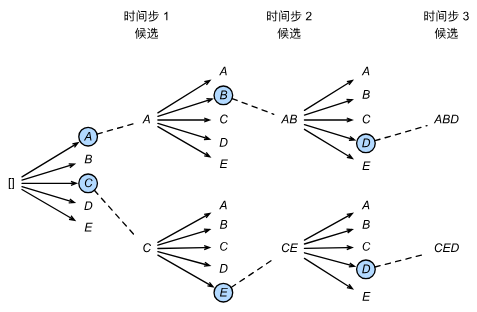
图9.8.3 束搜索过程（束宽：2，输出序列的最大长度：3）。候选输出序列是$A$、$C$、$AB$、$CE$、$ABD$和$CED$

[图9.8.3](#fig.9.8.3)演示了束搜索的过程。
假设输出的词表只包含五个元素：
$\mathcal{Y} = \{A, B, C, D, E\}$，
其中有一个是“&lt;eos&gt;”。
设置束宽为$2$，输出序列的最大长度为$3$。
在时间步$1$，假设具有最高条件概率
$P(y_1 \mid \mathbf{c})$的词元是$A$和$C$。
在时间步$2$，我们计算所有$y_2 \in \mathcal{Y}$为：

<span id='eq.9.8.2'></span>
$$ \begin{align} 
P(A, y_2 \mid \mathbf{c}) = P(A \mid \mathbf{c})P(y_2 \mid A, \mathbf{c}),\\
P(C, y_2 \mid \mathbf{c}) = P(C \mid \mathbf{c})P(y_2 \mid C, \mathbf{c}),
\end{align} \tag{9.8.2}$$  

从这十个值中选择最大的两个，
比如$P(A, B \mid \mathbf{c})$和$P(C, E \mid \mathbf{c})$。
然后在时间步$3$，我们计算所有$y_3 \in \mathcal{Y}$为：

<span id='eq.9.8.3'></span>
$$ \begin{align}
P(A, B, y_3 \mid \mathbf{c}) = P(A, B \mid \mathbf{c})P(y_3 \mid A, B, \mathbf{c}),\\
P(C, E, y_3 \mid \mathbf{c}) = P(C, E \mid \mathbf{c})P(y_3 \mid C, E, \mathbf{c}),
\end{align} \tag{9.8.3} $$ 

从这十个值中选择最大的两个，
即$P(A, B, D \mid \mathbf{c})$和$P(C, E, D \mid  \mathbf{c})$，
我们会得到六个候选输出序列：
（1）$A$；（2）$C$；（3）$A,B$；（4）$C,E$；（5）$A,B,D$；（6）$C,E,D$。

最后，基于这六个序列（例如，丢弃包括“&lt;eos&gt;”和之后的部分），
我们获得最终候选输出序列集合。
然后我们选择其中条件概率乘积最高的序列作为输出序列：

<span id='eq.9.8.4'></span>
$$ \frac{1}{L^\alpha} \log P(y_1, \ldots, y_{L}\mid \mathbf{c}) = \frac{1}{L^\alpha} \sum_{t'=1}^L \log P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c}), \tag{9.8.4}$$

其中$L$是最终候选序列的长度，
$\alpha$通常设置为$0.75$。
因为一个较长的序列在([9.8.4](#eq.9.8.4))的求和中会有更多的对数项，
因此分母中的$L^\alpha$用于惩罚长序列。

束搜索的计算量为$\mathcal{O}(k\left|\mathcal{Y}\right|T')$，
这个结果介于贪心搜索和穷举搜索之间。
实际上，贪心搜索可以看作一种束宽为$1$的特殊类型的束搜索。
通过灵活地选择束宽，束搜索可以在正确率和计算代价之间进行权衡。

### 小结

* 序列搜索策略包括贪心搜索、穷举搜索和束搜索。
* 贪心搜索所选取序列的计算量最小，但精度相对较低。
* 穷举搜索所选取序列的精度最高，但计算量最大。
* 束搜索通过灵活选择束宽，在正确率和计算代价之间进行权衡。